#### Prelude

In [ ]:
!pip install torch torchaudio datasets

In [ ]:
import torch
import librosa
import os
import numpy as np
import random
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from typing import List, Dict, Tuple
from torch import Tensor
from datasets import Audio, Dataset, load_dataset
from huggingface_hub import login

my_token = "REDACTED"

assert my_token != "REDACTED", "Please provide a huggingface token."
login(token=my_token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
if torch.cuda.is_available():
    dev = "cuda:0"
    print("Using GPU")
else:
    print("No GPU, training may be slow")
    dev = "cpu"

Using GPU


### Preprocessing

In [ ]:
MIN_SECONDS = 3
# Determine classes
accents = {"United States English": 0,
               "England English": 1,
               "India and South Asia (India, Pakistan, Sri Lanka)": 2}
sampling_rate = 16_000


def process_data(dataset: Dataset, filter: bool = True, mspec_only: bool = False) -> Dataset:
    """Preprocessing data pipeline.

    Note that the dataset is not modified in place.
    """

    def encode_accent(example):
        example['accent'] = accents[example['accent']]
        return example

    def trim_audio(example):
        example["audio"]["array"], index = librosa.effects.trim(y=example["audio"]["array"])
        return batch

    def crop_audio(batch):
        batch["audio"]["array"] = batch["audio"]["array"][:MIN_SECONDS * sampling_rate]
        return batch

    def extract_features(example):
        audio = example["audio"]
        example["mspec"] = librosa.feature.melspectrogram(y=audio["array"], sr=audio["sampling_rate"], n_mels=64, power=1.0).astype("double")
        if not mspec_only:
          example["log_mspec"] = librosa.amplitude_to_db(example["mspec"])
          example["mfcc"] = librosa.feature.mfcc(y=audio["array"], n_mfcc=13, sr=audio["sampling_rate"]).astype("double")
        return example

    def add_noise(example, STD_n=0.001):
        noise = np.random.normal(0, STD_n, example["audio"]["array"].shape[0])
        example["audio"]["array"] = example["audio"]["array"]+ noise
        return example

    def balance_data(example):
        return example["accent"] != "United States English" or random.randint(0, 2) == 0

    # Remove columns other than audio and accent
    # n.b. using a list rather than a set so that caching works
    dataset = dataset.select_columns(["audio", "accent"])
    # Fix sampling rate
    dataset = dataset.cast_column("audio", Audio(sampling_rate=sampling_rate))

    # Remove unwanted accents
    dataset = dataset.filter(lambda x: x["accent"] in accents)

    if filter:
      # Remove a third of US accent samples to balance the data

      # Set the random seed here so that filtered data is consistent,
      # meaning that the Hugging Face library can use the same cache
      # between runs.
      random.seed(a=1)
      dataset = dataset.filter(balance_data)

    # Trim silence at beginning and end of clip
    dataset = dataset.map(trim_audio)

    # Filter out short clips
    # n.b. this has to be done *after* trimming
    dataset = dataset.filter(lambda clip: clip["audio"]["array"].shape[0] > MIN_SECONDS * sampling_rate)

    # Trim anything past MIN_SECONDS
    dataset = dataset.map(crop_audio)

    # Encode labels
    dataset = dataset.map(encode_accent)

    # Add gaussian noise
    dataset = dataset.map(add_noise)

    # Feature Extraction
    dataset = dataset.map(extract_features)

    # Remove raw audio column now that we've computed MFCCs and MSpecs
    dataset = dataset.remove_columns(["audio"])

    # Shuffle data
    # Use seed to ensure consistent shuffle
    dataset = dataset.shuffle(seed=42)

    # Convert into pytorch tensors and move to GPU if applicable
    dataset = dataset.with_format("torch", device=dev)

    return dataset

In [ ]:
# Load Common Voice dataset from Hugging Face
dataset = load_dataset("mozilla-foundation/common_voice_13_0", "en", split="train", cache_dir="cache")

dataset = process_data(dataset)

# Batching
dataloader = DataLoader(dataset, batch_size=64)

# Compute class weights based on data
weights = compute_class_weight("balanced", classes=[0, 1, 2], y=dataset["train"].select_columns(["accent"]).to_pandas()["accent"])

In [ ]:
# Load Validation set
val = load_dataset("mozilla-foundation/common_voice_13_0", "en", split="validation", cache_dir="cache")

val = process_data(val, filter=False)

# Batching
valloader = DataLoader(val, batch_size=32)

In [ ]:
# Load test set
test = load_dataset("mozilla-foundation/common_voice_13_0", "en", split="test", cache_dir="cache")

test = process_data(test, filter=False, mspec_only=True)

# Batching
testloader = DataLoader(test, batch_size=32)

#### Data Exploration

In [ ]:
# Load .tsv file for Common Voice
filename = "/content/drive/MyDrive/Diss/CV13/train.tsv"
data = pd.read_csv(filename, sep='\t')

In [ ]:
# Drop items with no accent value
data = data.dropna(subset=["accents"])

In [ ]:
# Top 30 accents based on number of samples
accents = data["accents"].value_counts()
accents[0:30]

United States English                                               262964
England English                                                      80966
India and South Asia (India, Pakistan, Sri Lanka)                    80488
Canadian English                                                     49129
German English,Non native speaker                                    44314
Australian English                                                   34095
Scottish English                                                     11435
Northern Irish                                                        8671
Irish English                                                         6527
New Zealand English                                                   5675
Southern African (South Africa, Zimbabwe, Namibia)                    4565
Filipino                                                              4024
Hong Kong English                                                     2989
Singaporean English      

In [ ]:
# Top 30 samples based on number of unique speakers
data = data.drop_duplicates(subset="client_id", keep="last")
unique_accents = data["accents"].value_counts()
unique_accents[0:30]

United States English                                                      4772
England English                                                            1405
India and South Asia (India, Pakistan, Sri Lanka)                          1168
Canadian English                                                            596
Australian English                                                          408
Southern African (South Africa, Zimbabwe, Namibia)                          142
Irish English                                                               111
Scottish English                                                            100
New Zealand English                                                          96
Filipino                                                                     77
Hong Kong English                                                            73
Malaysian English                                                            59
Singaporean English                     

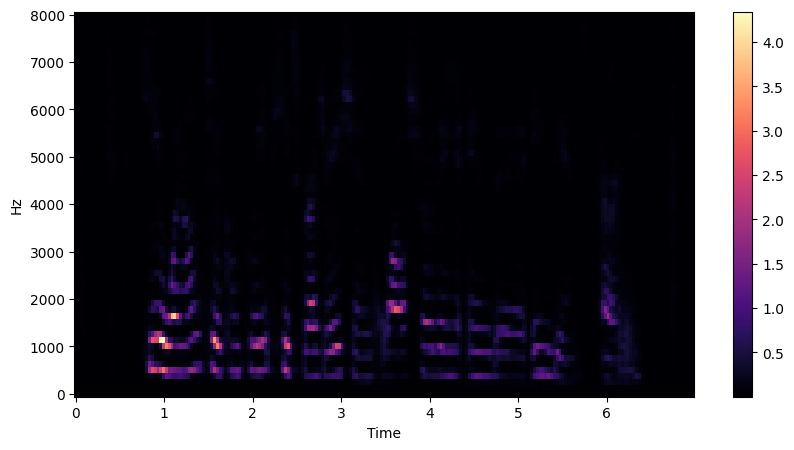

In [ ]:
# Display Linear Mel-Spectrogram

mspec = dataset["mspec"][0]
plt.figure(figsize=(10, 5))
librosa.display.specshow(mspec, sr=sampling_rate, x_axis="time", y_axis="hz")
plt.colorbar();

In [ ]:
dataset.select_columns(["accent"]).to_pandas()["accent"].value_counts()

0    57893
1    51962
2    32817
Name: accent, dtype: int64

In [ ]:
val.select_columns(["accent"]).to_pandas()["accent"].value_counts()

0    836
1    330
2    196
Name: accent, dtype: int64

In [ ]:
test.select_columns(["accent"]).to_pandas()["accent"].value_counts()

0    615
2    327
1    171
Name: accent, dtype: int64

### Network Design


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from tqdm import tqdm

In [ ]:
# Neural Network 1D

def build_1d_net(column: str):
    return Net1D(column).to(dev)


class Net1D(nn.Module):
    def __init__(self, column: str):
        super().__init__()
        if column =='mfcc':
            input_dim = 13 # Use for mfccs
        else:
            input_dim = 64 # Use for mspecs
        self.conv1 = nn.Conv1d(input_dim, 6, 5)
        self.bn1 = nn.BatchNorm1d(6)
        self.pool1 = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(6, 16, 5)
        self.bn2 = nn.BatchNorm1d(16)
        self.pool2 = nn.MaxPool1d(2, 2)
        self.drop = nn.Dropout(0.2)
        self.fc1 = nn.Linear(816, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool1(x)
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool2(x)
        x = self.drop(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Neural Network 2D

def build_2d_net(column: str):
    return Net2D(column).to(dev)

class Net2D(nn.Module):
    def __init__(self, column: str):
        super().__init__()
        if column =='mfcc':
            fc1_dim = 3392 # Use for mfccs
        else:
            fc1_dim = 47488 # Use for mspecs
        self.conv1 = nn.Conv2d(1, 32, (3, 3))
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, (3, 3))
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(fc1_dim, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        # Add channel dimension
        x = x.unsqueeze(1)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool1(x)
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

In [ ]:
# Training

def train_model(model: nn.Module, column: str, epochs: int = 50, lr: float = 0.001, evalloader: DataLoader = valloader):

    criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights).float().to(dev))
    optimizer = optim.Adam(model.parameters(), lr=lr)

    val_loss = []
    val_accuracy = []
    train_loss = []
    train_accuracy = []

    for epoch in range(epochs):
        # Measure loss on training set
        train_correct = 0
        train_total = 0
        train_running_loss = 0.0
        for i, data in enumerate(tqdm(dataloader)):
            # zero the parameter gradients
            optimizer.zero_grad()

            outputs, labels, inputs = generate_outputs(model, column, data)

            # forward + backward + optimize
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_correct, batch_total = calculate_accuracy(outputs, labels)
            train_running_loss += loss.item()
            train_correct += batch_correct
            train_total += batch_total
        train_loss.append(train_running_loss)
        train_accuracy.append(train_correct / train_total)

        # Measure loss on validation set
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0
        for batch in tqdm(evalloader):
            val_outputs, val_labels, _ = generate_outputs(model, column, batch)
            batch_val_correct, batch_val_total = calculate_accuracy(val_outputs, val_labels)
            val_correct += batch_val_correct
            val_total += batch_val_total
            val_running_loss += criterion(val_outputs, val_labels).item()
        val_loss.append(val_running_loss)
        val_accuracy.append(val_correct / val_total)

        print(f"[{epoch + 1}] validation loss,  validation accuracy: {val_running_loss:.3f}, {val_correct / val_total}. train loss, train accuracy: {train_running_loss:.3f}, {train_correct / train_total}")

    print("Finished Training")
    print(train_loss, train_accuracy, val_loss, val_accuracy)
    return model


def generate_outputs(model, column, data):
    inputs, labels = data[column].float(), data["accent"]
    outputs = model(inputs)
    return outputs, labels, inputs

def calculate_predictions(outputs):
    _, predicted = torch.max(outputs.data, 1)
    return predicted

def calculate_accuracy(outputs, labels):
    predicted = calculate_predictions(outputs)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct, total

### Experiment 1: Input Features and Model Dimension

#### MFCCs

In [ ]:
net1 = build_1d_net("mfcc")

net1 = train_model(net1, "mfcc", epochs=10)

  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[1] validation loss,  validation accuracy: 23.359, 0.48091042584434657. train loss, train accuracy: 2031.402, 0.5589674217786251


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[2] validation loss,  validation accuracy: 23.456, 0.4720998531571219. train loss, train accuracy: 1887.714, 0.602024223393518


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[3] validation loss,  validation accuracy: 23.588, 0.45961820851688695. train loss, train accuracy: 1834.921, 0.6136452842884378


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[4] validation loss,  validation accuracy: 23.890, 0.4552129221732746. train loss, train accuracy: 1796.395, 0.6242430189525625


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[5] validation loss,  validation accuracy: 24.000, 0.461086637298091. train loss, train accuracy: 1768.474, 0.629394695525401


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[6] validation loss,  validation accuracy: 24.148, 0.460352422907489. train loss, train accuracy: 1747.121, 0.6345814175171022


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[7] validation loss,  validation accuracy: 24.003, 0.473568281938326. train loss, train accuracy: 1721.514, 0.6405181114724683


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[8] validation loss,  validation accuracy: 24.425, 0.47430249632892807. train loss, train accuracy: 1703.922, 0.646153414825614


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[9] validation loss,  validation accuracy: 24.501, 0.4618208516886931. train loss, train accuracy: 1689.493, 0.6479407311876192


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[10] validation loss,  validation accuracy: 24.781, 0.48604992657856094. train loss, train accuracy: 1673.490, 0.6510247280475496
Finished Training


([2031.402475118637,
  1887.7138754725456,
  1834.9213252067566,
  1796.3947339057922,
  1768.4738354682922,
  1747.1206159591675,
  1721.5141465067863,
  1703.9215866327286,
  1689.4926107525826,
  1673.4904533028603],
 [0.5589674217786251,
  0.602024223393518,
  0.6136452842884378,
  0.6242430189525625,
  0.629394695525401,
  0.6345814175171022,
  0.6405181114724683,
  0.646153414825614,
  0.6479407311876192,
  0.6510247280475496],
 [23.359007596969604,
  23.45583140850067,
  23.587631583213806,
  23.890394389629364,
  23.99955177307129,
  24.147662103176117,
  24.00338113307953,
  24.425440192222595,
  24.501083433628082,
  24.780794322490692],
 [0.48091042584434657,
  0.4720998531571219,
  0.45961820851688695,
  0.4552129221732746,
  0.461086637298091,
  0.460352422907489,
  0.473568281938326,
  0.47430249632892807,
  0.4618208516886931,
  0.48604992657856094])

In [ ]:
net2 = build_2d_net("mfcc")

net2 = train_model(net2, "mfcc", epochs=10)

  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[1] validation loss,  validation accuracy: 21.283, 0.4985315712187959. train loss, train accuracy: 1892.553, 0.5978958730514747


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[2] validation loss,  validation accuracy: 22.301, 0.5124816446402349. train loss, train accuracy: 1625.544, 0.6700263541549849


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[3] validation loss,  validation accuracy: 22.681, 0.513215859030837. train loss, train accuracy: 1500.689, 0.6975650442974094


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[4] validation loss,  validation accuracy: 25.690, 0.5022026431718062. train loss, train accuracy: 1391.674, 0.7211576202758775


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[5] validation loss,  validation accuracy: 29.774, 0.5124816446402349. train loss, train accuracy: 1291.130, 0.7403134462263093


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[6] validation loss,  validation accuracy: 31.128, 0.5007342143906021. train loss, train accuracy: 1197.833, 0.7581585735112706


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[7] validation loss,  validation accuracy: 32.175, 0.47430249632892807. train loss, train accuracy: 1118.072, 0.7744196478636313


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[8] validation loss,  validation accuracy: 35.954, 0.4919236417033774. train loss, train accuracy: 1042.271, 0.7892018055399798


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[9] validation loss,  validation accuracy: 40.196, 0.4684287812041116. train loss, train accuracy: 980.033, 0.8007808119322642


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[10] validation loss,  validation accuracy: 42.202, 0.5058737151248165. train loss, train accuracy: 923.301, 0.8129205450263541
Finished Training


([1892.5530275702477,
  1625.5438874661922,
  1500.689269632101,
  1391.6741563081741,
  1291.1301757991314,
  1197.8326736986637,
  1118.0721361339092,
  1042.2711163908243,
  980.032955929637,
  923.3014480769634],
 [0.5978958730514747,
  0.6700263541549849,
  0.6975650442974094,
  0.7211576202758775,
  0.7403134462263093,
  0.7581585735112706,
  0.7744196478636313,
  0.7892018055399798,
  0.8007808119322642,
  0.8129205450263541],
 [21.28326666355133,
  22.30130922794342,
  22.68081897497177,
  25.689533710479736,
  29.773975491523743,
  31.12777304649353,
  32.175474882125854,
  35.95445013046265,
  40.1956370472908,
  42.202311873435974],
 [0.4985315712187959,
  0.5124816446402349,
  0.513215859030837,
  0.5022026431718062,
  0.5124816446402349,
  0.5007342143906021,
  0.47430249632892807,
  0.4919236417033774,
  0.4684287812041116,
  0.5058737151248165])

#### Log MSpec

In [ ]:
net3 = build_1d_net('log_mspec')

net3 = train_model(net3, 'log_mspec', epochs=10)

  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[1] validation loss,  validation accuracy: 22.950, 0.47063142437591776. train loss, train accuracy: 2027.330, 0.5411713580800718


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[2] validation loss,  validation accuracy: 23.096, 0.4955947136563877. train loss, train accuracy: 1814.543, 0.6108837052820455


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[3] validation loss,  validation accuracy: 22.731, 0.5117474302496329. train loss, train accuracy: 1742.033, 0.6316025569137602


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[4] validation loss,  validation accuracy: 22.479, 0.5176211453744494. train loss, train accuracy: 1692.404, 0.643826399013121


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[5] validation loss,  validation accuracy: 22.534, 0.5095447870778267. train loss, train accuracy: 1654.247, 0.6542979701693394


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[6] validation loss,  validation accuracy: 23.024, 0.5088105726872246. train loss, train accuracy: 1620.448, 0.6617696534708983


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[7] validation loss,  validation accuracy: 22.465, 0.5190895741556535. train loss, train accuracy: 1596.836, 0.6666409666928339


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[8] validation loss,  validation accuracy: 23.081, 0.5161527165932452. train loss, train accuracy: 1575.059, 0.6731524055175507


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[9] validation loss,  validation accuracy: 23.049, 0.5227606461086637. train loss, train accuracy: 1555.776, 0.6778555007289447


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[10] validation loss,  validation accuracy: 23.705, 0.5154185022026432. train loss, train accuracy: 1541.036, 0.6800493439497589
Finished Training


([2027.3298351168633,
  1814.543279826641,
  1742.0331949591637,
  1692.403606235981,
  1654.246504932642,
  1620.4483275413513,
  1596.8360548317432,
  1575.058591812849,
  1555.7761256098747,
  1541.0360026061535],
 [0.5411713580800718,
  0.6108837052820455,
  0.6316025569137602,
  0.643826399013121,
  0.6542979701693394,
  0.6617696534708983,
  0.6666409666928339,
  0.6731524055175507,
  0.6778555007289447,
  0.6800493439497589],
 [22.95020991563797,
  23.09557396173477,
  22.731460213661194,
  22.47877562046051,
  22.534360110759735,
  23.024313926696777,
  22.464654684066772,
  23.081133902072906,
  23.048945784568787,
  23.704729914665222],
 [0.47063142437591776,
  0.4955947136563877,
  0.5117474302496329,
  0.5176211453744494,
  0.5095447870778267,
  0.5088105726872246,
  0.5190895741556535,
  0.5161527165932452,
  0.5227606461086637,
  0.5154185022026432])

In [ ]:
net4 = build_2d_net('log_mspec')

net4 = train_model(net4, 'log_mspec', epochs=10)

  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[1] validation loss,  validation accuracy: 22.498, 0.4955947136563877. train loss, train accuracy: 1850.472, 0.591755915666704


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[2] validation loss,  validation accuracy: 22.599, 0.5381791483113069. train loss, train accuracy: 1415.635, 0.7161321072109453


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[3] validation loss,  validation accuracy: 25.150, 0.5418502202643172. train loss, train accuracy: 1151.643, 0.7735645396433778


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[4] validation loss,  validation accuracy: 30.122, 0.5433186490455213. train loss, train accuracy: 927.462, 0.8213805091398453


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[5] validation loss,  validation accuracy: 32.644, 0.5286343612334802. train loss, train accuracy: 752.854, 0.8565941460132331


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[6] validation loss,  validation accuracy: 39.498, 0.5176211453744494. train loss, train accuracy: 613.519, 0.8846304811035102


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[7] validation loss,  validation accuracy: 43.562, 0.5066079295154186. train loss, train accuracy: 504.051, 0.9057979140966693


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[8] validation loss,  validation accuracy: 46.639, 0.527165932452276. train loss, train accuracy: 439.005, 0.9190871369294605


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[9] validation loss,  validation accuracy: 55.392, 0.5029368575624082. train loss, train accuracy: 381.342, 0.9301825165414377


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[10] validation loss,  validation accuracy: 57.901, 0.5117474302496329. train loss, train accuracy: 334.630, 0.9388527531681059
Finished Training


([1850.4717335104942,
  1415.6353498399258,
  1151.6425010859966,
  927.4622901976109,
  752.8543989211321,
  613.5193878188729,
  504.05112118273973,
  439.0054038017988,
  381.34183830581605,
  334.6298323906958],
 [0.591755915666704,
  0.7161321072109453,
  0.7735645396433778,
  0.8213805091398453,
  0.8565941460132331,
  0.8846304811035102,
  0.9057979140966693,
  0.9190871369294605,
  0.9301825165414377,
  0.9388527531681059],
 [22.49761950969696,
  22.599190890789032,
  25.150100767612457,
  30.122468531131744,
  32.64408528804779,
  39.49849021434784,
  43.5616774559021,
  46.63922441005707,
  55.39181709289551,
  57.901381492614746],
 [0.4955947136563877,
  0.5381791483113069,
  0.5418502202643172,
  0.5433186490455213,
  0.5286343612334802,
  0.5176211453744494,
  0.5066079295154186,
  0.527165932452276,
  0.5029368575624082,
  0.5117474302496329])

#### Linear MSpec

In [ ]:
net5 = build_1d_net('mspec')

net5 = train_model(net5, 'mspec', epochs=10)

  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[1] validation loss,  validation accuracy: 23.314, 0.44052863436123346. train loss, train accuracy: 2118.060, 0.4946941235841651


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[2] validation loss,  validation accuracy: 23.158, 0.4522760646108664. train loss, train accuracy: 1966.875, 0.5487832230570819


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[3] validation loss,  validation accuracy: 23.040, 0.48237885462555063. train loss, train accuracy: 1902.173, 0.57161180890434


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[4] validation loss,  validation accuracy: 23.535, 0.4566813509544787. train loss, train accuracy: 1857.090, 0.5863519120780532


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[5] validation loss,  validation accuracy: 23.711, 0.47577092511013214. train loss, train accuracy: 1824.600, 0.5969846921610407


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[6] validation loss,  validation accuracy: 23.901, 0.48384728340675476. train loss, train accuracy: 1795.318, 0.6057039923741169


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[7] validation loss,  validation accuracy: 24.018, 0.4801762114537445. train loss, train accuracy: 1771.616, 0.6124747672984188


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[8] validation loss,  validation accuracy: 24.056, 0.4669603524229075. train loss, train accuracy: 1747.369, 0.6180399798138387


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[9] validation loss,  validation accuracy: 24.339, 0.47577092511013214. train loss, train accuracy: 1731.362, 0.622722047773915


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[10] validation loss,  validation accuracy: 24.456, 0.473568281938326. train loss, train accuracy: 1710.986, 0.6284064147134687
Finished Training


([2118.0598185658455,
  1966.87490016222,
  1902.1730853915215,
  1857.089740216732,
  1824.5999776124954,
  1795.3181765079498,
  1771.6158506274223,
  1747.3694624602795,
  1731.3619908690453,
  1710.9857587218285],
 [0.4946941235841651,
  0.5487832230570819,
  0.57161180890434,
  0.5863519120780532,
  0.5969846921610407,
  0.6057039923741169,
  0.6124747672984188,
  0.6180399798138387,
  0.622722047773915,
  0.6284064147134687],
 [23.31442755460739,
  23.158280313014984,
  23.039598882198334,
  23.534822404384613,
  23.71084463596344,
  23.900904893875122,
  24.018145620822906,
  24.05577528476715,
  24.33888405561447,
  24.456442177295685],
 [0.44052863436123346,
  0.4522760646108664,
  0.48237885462555063,
  0.4566813509544787,
  0.47577092511013214,
  0.48384728340675476,
  0.4801762114537445,
  0.4669603524229075,
  0.47577092511013214,
  0.473568281938326])

In [ ]:
net6 = build_2d_net('mspec')

net6 = train_model(net6, 'mspec', epochs=10)

  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[1] validation loss,  validation accuracy: 22.670, 0.4985315712187959. train loss, train accuracy: 1907.438, 0.5720814175171022


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[2] validation loss,  validation accuracy: 23.700, 0.5234948604992657. train loss, train accuracy: 1498.027, 0.6944950656050242


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[3] validation loss,  validation accuracy: 26.410, 0.5462555066079295. train loss, train accuracy: 1234.126, 0.7537218234832342


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[4] validation loss,  validation accuracy: 31.674, 0.5234948604992657. train loss, train accuracy: 1001.946, 0.8044675899966356


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[5] validation loss,  validation accuracy: 35.658, 0.5220264317180616. train loss, train accuracy: 825.498, 0.8407325894359089


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[6] validation loss,  validation accuracy: 42.729, 0.5308370044052864. train loss, train accuracy: 677.927, 0.8712291129303578


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[7] validation loss,  validation accuracy: 43.956, 0.526431718061674. train loss, train accuracy: 574.998, 0.8939946170236627


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[8] validation loss,  validation accuracy: 48.887, 0.5447870778267254. train loss, train accuracy: 482.562, 0.9115243355388584


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[9] validation loss,  validation accuracy: 50.047, 0.5425844346549192. train loss, train accuracy: 425.571, 0.9229140966692834


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[10] validation loss,  validation accuracy: 56.712, 0.5315712187958884. train loss, train accuracy: 373.935, 0.9327408321184255
Finished Training


([1907.4377993047237,
  1498.0268660187721,
  1234.1260098069906,
  1001.9461295008659,
  825.4979017525911,
  677.9271319881082,
  574.9980086237192,
  482.56190081872046,
  425.5713594891131,
  373.935325731989],
 [0.5720814175171022,
  0.6944950656050242,
  0.7537218234832342,
  0.8044675899966356,
  0.8407325894359089,
  0.8712291129303578,
  0.8939946170236627,
  0.9115243355388584,
  0.9229140966692834,
  0.9327408321184255],
 [22.669596910476685,
  23.700080931186676,
  26.409769356250763,
  31.67371928691864,
  35.65787994861603,
  42.728824853897095,
  43.95581543445587,
  48.88666796684265,
  50.04688662290573,
  56.71221423149109],
 [0.4985315712187959,
  0.5234948604992657,
  0.5462555066079295,
  0.5234948604992657,
  0.5220264317180616,
  0.5308370044052864,
  0.526431718061674,
  0.5447870778267254,
  0.5425844346549192,
  0.5315712187958884])

### Experiment 2: Learning Rate and Batch Size

In [ ]:
# Remove unnecessary input feature columnns
dataset = dataset.remove_columns(["log_mspec", "mfcc"])

#### Batch Size 32

In [ ]:
# Batching
dataloader = DataLoader(dataset, batch_size=32)

In [ ]:
# Batch Size 32, learning rate 0.001

net7 = build_2d_net("mspec")

net7 = train_model(net7, "mspec", epochs=50)

# Whilst the model was trained for 50 epochs only the first 20 epochs were compared to the other models.
# This is because this was the first model trained, after this the number of epochs analysed for this experiment was reduced to 20 to save time.

  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[1] validation loss,  validation accuracy: 21.439, 0.5367107195301027. train loss, train accuracy: 3795.718, 0.5794269373107548


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[2] validation loss,  validation accuracy: 22.784, 0.5594713656387665. train loss, train accuracy: 3034.407, 0.69052792418975


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[3] validation loss,  validation accuracy: 24.579, 0.5433186490455213. train loss, train accuracy: 2580.236, 0.7434465066726478


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[4] validation loss,  validation accuracy: 29.719, 0.5440528634361234. train loss, train accuracy: 2180.743, 0.7868046988897611


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[5] validation loss,  validation accuracy: 30.428, 0.5690161527165932. train loss, train accuracy: 1862.330, 0.819936637882696


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[6] validation loss,  validation accuracy: 37.562, 0.5675477239353891. train loss, train accuracy: 1606.304, 0.8477206459571605


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[7] validation loss,  validation accuracy: 41.376, 0.5550660792951542. train loss, train accuracy: 1414.308, 0.8670026354154985


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[8] validation loss,  validation accuracy: 45.838, 0.5506607929515418. train loss, train accuracy: 1275.019, 0.8820651564427499


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[9] validation loss,  validation accuracy: 54.775, 0.5580029368575624. train loss, train accuracy: 1156.547, 0.8923334641695637


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[10] validation loss,  validation accuracy: 54.313, 0.5433186490455213. train loss, train accuracy: 1025.873, 0.9060011775260738


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[11] validation loss,  validation accuracy: 55.120, 0.5565345080763583. train loss, train accuracy: 948.294, 0.9132205338118201


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[12] validation loss,  validation accuracy: 50.858, 0.5602055800293686. train loss, train accuracy: 888.870, 0.9203417629247505


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[13] validation loss,  validation accuracy: 59.710, 0.5345080763582967. train loss, train accuracy: 817.202, 0.9272877649433666


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[14] validation loss,  validation accuracy: 61.965, 0.5389133627019089. train loss, train accuracy: 744.288, 0.9339604126948525


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[15] validation loss,  validation accuracy: 70.552, 0.5183553597650514. train loss, train accuracy: 698.390, 0.93850930806325


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[16] validation loss,  validation accuracy: 65.941, 0.5381791483113069. train loss, train accuracy: 659.731, 0.9420418862846248


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[17] validation loss,  validation accuracy: 65.935, 0.55359765051395. train loss, train accuracy: 612.825, 0.9470043175956039


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[18] validation loss,  validation accuracy: 78.109, 0.5367107195301027. train loss, train accuracy: 584.401, 0.9491911517326455


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[19] validation loss,  validation accuracy: 78.386, 0.5425844346549192. train loss, train accuracy: 550.225, 0.9524363575193451


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[20] validation loss,  validation accuracy: 81.846, 0.5176211453744494. train loss, train accuracy: 520.790, 0.9563123808455759


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[21] validation loss,  validation accuracy: 83.255, 0.5433186490455213. train loss, train accuracy: 479.541, 0.9587445329146574


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[22] validation loss,  validation accuracy: 91.173, 0.5425844346549192. train loss, train accuracy: 453.679, 0.9613449029942805


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[23] validation loss,  validation accuracy: 95.338, 0.5389133627019089. train loss, train accuracy: 439.686, 0.9629219468431087


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[24] validation loss,  validation accuracy: 88.224, 0.5220264317180616. train loss, train accuracy: 432.588, 0.9644919816081642


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[25] validation loss,  validation accuracy: 89.668, 0.5323054331864905. train loss, train accuracy: 401.617, 0.966755915666704


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[26] validation loss,  validation accuracy: 93.744, 0.5345080763582967. train loss, train accuracy: 391.716, 0.9682418414264887


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[27] validation loss,  validation accuracy: 93.196, 0.5389133627019089. train loss, train accuracy: 391.461, 0.9676390602220478


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[28] validation loss,  validation accuracy: 103.955, 0.5506607929515418. train loss, train accuracy: 350.679, 0.9704146573959852


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[29] validation loss,  validation accuracy: 98.339, 0.5411160058737151. train loss, train accuracy: 351.265, 0.9713749018728272


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[30] validation loss,  validation accuracy: 100.330, 0.527165932452276. train loss, train accuracy: 357.480, 0.9714309745430078


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[31] validation loss,  validation accuracy: 95.913, 0.5469897209985316. train loss, train accuracy: 335.013, 0.9733584725804643


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[32] validation loss,  validation accuracy: 122.758, 0.5139500734214391. train loss, train accuracy: 306.590, 0.975510261298643


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[33] validation loss,  validation accuracy: 127.075, 0.5293685756240822. train loss, train accuracy: 314.997, 0.9745570259055736


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[34] validation loss,  validation accuracy: 125.743, 0.5352422907488987. train loss, train accuracy: 306.658, 0.9754191432095997


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[35] validation loss,  validation accuracy: 113.148, 0.5337738619676946. train loss, train accuracy: 290.336, 0.9769611416395648


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[36] validation loss,  validation accuracy: 115.627, 0.5418502202643172. train loss, train accuracy: 310.080, 0.9759868789951778


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[37] validation loss,  validation accuracy: 100.310, 0.539647577092511. train loss, train accuracy: 290.947, 0.9771994504878322


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[38] validation loss,  validation accuracy: 115.398, 0.5484581497797357. train loss, train accuracy: 286.397, 0.9777952226085006


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[39] validation loss,  validation accuracy: 128.959, 0.5337738619676946. train loss, train accuracy: 270.466, 0.9780755859594034


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[40] validation loss,  validation accuracy: 134.540, 0.55359765051395. train loss, train accuracy: 262.643, 0.9789096669283391


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[41] validation loss,  validation accuracy: 113.321, 0.5411160058737151. train loss, train accuracy: 264.793, 0.9789236850958842


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[42] validation loss,  validation accuracy: 115.135, 0.5447870778267254. train loss, train accuracy: 256.298, 0.97951244813278


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[43] validation loss,  validation accuracy: 136.730, 0.5352422907488987. train loss, train accuracy: 267.692, 0.9790358304362454


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[44] validation loss,  validation accuracy: 126.672, 0.5330396475770925. train loss, train accuracy: 239.184, 0.9806759560390266


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[45] validation loss,  validation accuracy: 136.575, 0.5330396475770925. train loss, train accuracy: 241.308, 0.9806969832903443


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[46] validation loss,  validation accuracy: 126.949, 0.5352422907488987. train loss, train accuracy: 231.200, 0.9813978916676012


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[47] validation loss,  validation accuracy: 120.262, 0.5469897209985316. train loss, train accuracy: 233.345, 0.9814329370864641


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[48] validation loss,  validation accuracy: 147.010, 0.5359765051395007. train loss, train accuracy: 228.704, 0.9819936637882696


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[49] validation loss,  validation accuracy: 151.247, 0.540381791483113. train loss, train accuracy: 231.520, 0.9818675002803634


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[50] validation loss,  validation accuracy: 132.850, 0.5425844346549192. train loss, train accuracy: 221.559, 0.9826455085791186
Finished Training


([3795.7184788882732,
  3034.406504660845,
  2580.2364516854286,
  2180.743188664317,
  1862.3298946395516,
  1606.304493445903,
  1414.30825407058,
  1275.0191887486726,
  1156.5467609837651,
  1025.8727226946503,
  948.2938462086022,
  888.8695690361783,
  817.2016572104767,
  744.2882745077368,
  698.3899033444468,
  659.7305507867131,
  612.8252860778011,
  584.4009887378197,
  550.225298082456,
  520.7903178595006,
  479.541025671002,
  453.67867582157487,
  439.6857754305238,
  432.58751209423644,
  401.61723069261643,
  391.71638495119987,
  391.4606512332102,
  350.6786518097142,
  351.26502167062426,
  357.48003126771073,
  335.0134519557105,
  306.5904519350297,
  314.9966814363652,
  306.657979520096,
  290.33633406899025,
  310.0795941516117,
  290.94695770880935,
  286.39660439590807,
  270.4663383217776,
  262.6428526181189,
  264.7930070854927,
  256.2978170267088,
  267.69202990764825,
  239.18431518084617,
  241.3077972431347,
  231.1996131156411,
  233.34542511779728,

In [ ]:
# Batch Size 32, learning rate 0.0001

net8 = build_2d_net("mspec")

net8 = train_model(net8, "mspec", epochs=20, lr=0.0001)

  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[1] validation loss,  validation accuracy: 22.492, 0.4955947136563877. train loss, train accuracy: 3892.887, 0.5624649545811371


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[2] validation loss,  validation accuracy: 23.257, 0.5286343612334802. train loss, train accuracy: 3059.801, 0.686280419423573


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[3] validation loss,  validation accuracy: 25.981, 0.5374449339207048. train loss, train accuracy: 2405.194, 0.7628967141415274


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[4] validation loss,  validation accuracy: 31.653, 0.5161527165932452. train loss, train accuracy: 1774.130, 0.8311581810025793


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[5] validation loss,  validation accuracy: 39.886, 0.5323054331864905. train loss, train accuracy: 1233.981, 0.8851982168890883


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[6] validation loss,  validation accuracy: 46.449, 0.5227606461086637. train loss, train accuracy: 844.996, 0.9226687787372435


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[7] validation loss,  validation accuracy: 58.703, 0.5117474302496329. train loss, train accuracy: 612.575, 0.9454132555792307


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[8] validation loss,  validation accuracy: 66.002, 0.5073421439060205. train loss, train accuracy: 489.497, 0.9577702702702703


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[9] validation loss,  validation accuracy: 71.685, 0.5190895741556535. train loss, train accuracy: 394.652, 0.9662792979701693


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[10] validation loss,  validation accuracy: 73.517, 0.5190895741556535. train loss, train accuracy: 330.527, 0.9720898284176293


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[11] validation loss,  validation accuracy: 80.392, 0.5117474302496329. train loss, train accuracy: 300.490, 0.9747532802512056


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[12] validation loss,  validation accuracy: 82.126, 0.5036710719530103. train loss, train accuracy: 265.576, 0.9781386677133566


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[13] validation loss,  validation accuracy: 78.720, 0.5198237885462555. train loss, train accuracy: 240.607, 0.9801713020074015


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[14] validation loss,  validation accuracy: 87.719, 0.5051395007342144. train loss, train accuracy: 216.457, 0.9821408545474936


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[15] validation loss,  validation accuracy: 97.057, 0.5124816446402349. train loss, train accuracy: 197.309, 0.9840963889200404


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[16] validation loss,  validation accuracy: 91.897, 0.526431718061674. train loss, train accuracy: 178.327, 0.9855612874285073


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[17] validation loss,  validation accuracy: 96.121, 0.5315712187958884. train loss, train accuracy: 168.521, 0.9863463048110351


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[18] validation loss,  validation accuracy: 92.343, 0.5330396475770925. train loss, train accuracy: 160.962, 0.9874537400471011


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[19] validation loss,  validation accuracy: 95.844, 0.5124816446402349. train loss, train accuracy: 146.351, 0.988315857351127


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[20] validation loss,  validation accuracy: 101.613, 0.5242290748898678. train loss, train accuracy: 137.896, 0.9890728383985645
Finished Training


([3892.8871406018734,
  3059.800730586052,
  2405.1941450983286,
  1774.1302393302321,
  1233.9809079859406,
  844.9959965357557,
  612.5746300970204,
  489.4973758496344,
  394.65179529134184,
  330.5266137806466,
  300.48985338112107,
  265.57565122283995,
  240.60740415440523,
  216.45667836570647,
  197.3089499322814,
  178.32738079303817,
  168.5210762953575,
  160.96247124243382,
  146.3509637776424,
  137.89591214011307],
 [0.5624649545811371,
  0.686280419423573,
  0.7628967141415274,
  0.8311581810025793,
  0.8851982168890883,
  0.9226687787372435,
  0.9454132555792307,
  0.9577702702702703,
  0.9662792979701693,
  0.9720898284176293,
  0.9747532802512056,
  0.9781386677133566,
  0.9801713020074015,
  0.9821408545474936,
  0.9840963889200404,
  0.9855612874285073,
  0.9863463048110351,
  0.9874537400471011,
  0.988315857351127,
  0.9890728383985645],
 [22.49151861667633,
  23.25655210018158,
  25.98081648349762,
  31.653149962425232,
  39.885964035987854,
  46.448978424072266,

In [ ]:
# Batch Size 32, learning rate 0.00001
net9 = build_2d_net("mspec")

net9 = train_model(net9, "mspec", epochs=20, lr=0.00001)

  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[1] validation loss,  validation accuracy: 23.555, 0.4155653450807636. train loss, train accuracy: 4292.989, 0.5009532353930695


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[2] validation loss,  validation accuracy: 23.097, 0.47944199706314244. train loss, train accuracy: 3803.607, 0.5852865313446226


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[3] validation loss,  validation accuracy: 23.099, 0.48604992657856094. train loss, train accuracy: 3482.393, 0.6338664909723001


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[4] validation loss,  validation accuracy: 23.076, 0.49632892804698975. train loss, train accuracy: 3210.512, 0.6714211618257261


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[5] validation loss,  validation accuracy: 23.475, 0.4985315712187959. train loss, train accuracy: 2965.345, 0.7034526746663676


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[6] validation loss,  validation accuracy: 23.549, 0.5168869309838473. train loss, train accuracy: 2735.642, 0.7314259280026915


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[7] validation loss,  validation accuracy: 24.669, 0.5124816446402349. train loss, train accuracy: 2507.217, 0.7589576090613435


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[8] validation loss,  validation accuracy: 25.843, 0.4985315712187959. train loss, train accuracy: 2281.930, 0.7847790736794886


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[9] validation loss,  validation accuracy: 26.907, 0.5117474302496329. train loss, train accuracy: 2066.052, 0.809458057642705


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[10] validation loss,  validation accuracy: 27.907, 0.5227606461086637. train loss, train accuracy: 1840.474, 0.8337375238308848


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[11] validation loss,  validation accuracy: 29.701, 0.5146842878120411. train loss, train accuracy: 1626.925, 0.8566992822698217


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[12] validation loss,  validation accuracy: 31.565, 0.5117474302496329. train loss, train accuracy: 1418.429, 0.8778176516765729


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[13] validation loss,  validation accuracy: 32.931, 0.5256975036710719. train loss, train accuracy: 1218.782, 0.8980598856117529


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[14] validation loss,  validation accuracy: 36.163, 0.5058737151248165. train loss, train accuracy: 1032.514, 0.9161082763261187


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[15] validation loss,  validation accuracy: 38.820, 0.5168869309838473. train loss, train accuracy: 865.156, 0.931738533138948


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[16] validation loss,  validation accuracy: 40.929, 0.5007342143906021. train loss, train accuracy: 720.336, 0.9452310194011438


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[17] validation loss,  validation accuracy: 43.847, 0.5029368575624082. train loss, train accuracy: 591.430, 0.9572586071548728


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[18] validation loss,  validation accuracy: 47.124, 0.5022026431718062. train loss, train accuracy: 487.384, 0.9656554895144107


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[19] validation loss,  validation accuracy: 51.277, 0.5051395007342144. train loss, train accuracy: 396.498, 0.9733584725804643


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[20] validation loss,  validation accuracy: 54.181, 0.4985315712187959. train loss, train accuracy: 328.945, 0.9780265223729954
Finished Training


([4292.988604307175,
  3803.606884509325,
  3482.3929119706154,
  3210.5120456516743,
  2965.3453435003757,
  2735.6423392295837,
  2507.217102497816,
  2281.9301447421312,
  2066.0519775152206,
  1840.4740542769432,
  1626.9249223023653,
  1418.429077297449,
  1218.78228969872,
  1032.514303099364,
  865.1559033095837,
  720.3360560126603,
  591.4301172532141,
  487.38408575952053,
  396.49769630935043,
  328.9451332464814],
 [0.5009532353930695,
  0.5852865313446226,
  0.6338664909723001,
  0.6714211618257261,
  0.7034526746663676,
  0.7314259280026915,
  0.7589576090613435,
  0.7847790736794886,
  0.809458057642705,
  0.8337375238308848,
  0.8566992822698217,
  0.8778176516765729,
  0.8980598856117529,
  0.9161082763261187,
  0.931738533138948,
  0.9452310194011438,
  0.9572586071548728,
  0.9656554895144107,
  0.9733584725804643,
  0.9780265223729954],
 [23.554876506328583,
  23.096678912639618,
  23.098905622959137,
  23.07581388950348,
  23.474530458450317,
  23.548819839954376,


#### Batch Size 64

In [ ]:
# Batching
dataloader = DataLoader(dataset, batch_size=64)

In [ ]:
# Batch size 64, learning rate 0.00001
net10 = build_2d_net("mspec")

net10 = train_model(net10, "mspec", epochs=20, lr=0.00001)

  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[1] validation loss,  validation accuracy: 23.687, 0.4118942731277533. train loss, train accuracy: 2169.138, 0.49253532578221376


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[2] validation loss,  validation accuracy: 23.940, 0.4177679882525698. train loss, train accuracy: 1951.034, 0.5666283503420433


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[3] validation loss,  validation accuracy: 24.475, 0.4280469897209985. train loss, train accuracy: 1818.171, 0.6077576539194797


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[4] validation loss,  validation accuracy: 24.166, 0.44493392070484583. train loss, train accuracy: 1707.066, 0.6390812492990916


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[5] validation loss,  validation accuracy: 24.761, 0.45080763582966227. train loss, train accuracy: 1609.655, 0.6675241112481777


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[6] validation loss,  validation accuracy: 24.958, 0.45741556534508077. train loss, train accuracy: 1512.358, 0.6927007401592464


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[7] validation loss,  validation accuracy: 25.325, 0.46622613803230545. train loss, train accuracy: 1420.135, 0.7145620724458899


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[8] validation loss,  validation accuracy: 25.846, 0.4684287812041116. train loss, train accuracy: 1332.103, 0.7354561511719188


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[9] validation loss,  validation accuracy: 26.514, 0.46916299559471364. train loss, train accuracy: 1240.233, 0.7582567006840866


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[10] validation loss,  validation accuracy: 27.085, 0.4853157121879589. train loss, train accuracy: 1152.055, 0.7790105977346641


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[11] validation loss,  validation accuracy: 27.245, 0.4845814977973568. train loss, train accuracy: 1066.559, 0.7983416507794101


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[12] validation loss,  validation accuracy: 28.741, 0.4911894273127753. train loss, train accuracy: 981.528, 0.8157732421217898


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[13] validation loss,  validation accuracy: 29.095, 0.4919236417033774. train loss, train accuracy: 894.909, 0.8350692497476729


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[14] validation loss,  validation accuracy: 30.773, 0.4919236417033774. train loss, train accuracy: 813.345, 0.8523326230795111


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[15] validation loss,  validation accuracy: 31.855, 0.4889867841409692. train loss, train accuracy: 735.161, 0.868166143321745


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[16] validation loss,  validation accuracy: 32.983, 0.5014684287812041. train loss, train accuracy: 660.653, 0.8838735000560727


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[17] validation loss,  validation accuracy: 35.419, 0.4831130690161527. train loss, train accuracy: 586.833, 0.8990902209263205


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[18] validation loss,  validation accuracy: 37.236, 0.4985315712187959. train loss, train accuracy: 520.386, 0.9127929797016934


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[19] validation loss,  validation accuracy: 39.076, 0.4933920704845815. train loss, train accuracy: 458.406, 0.9247504766176965


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[20] validation loss,  validation accuracy: 41.576, 0.4911894273127753. train loss, train accuracy: 401.999, 0.935628574632724


In [ ]:
# Batch size 64, learning rate 0.0001

net11 = build_2d_net("mspec")

net11 = train_model(net11, "mspec", epochs=25, lr=0.0001)

# Again only the first 20 epochs were analysed.

  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[1] validation loss,  validation accuracy: 23.274, 0.4779735682819383. train loss, train accuracy: 1984.514, 0.5508368846024447


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[2] validation loss,  validation accuracy: 23.750, 0.5102790014684288. train loss, train accuracy: 1576.064, 0.6734397779522261


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[3] validation loss,  validation accuracy: 26.259, 0.5161527165932452. train loss, train accuracy: 1253.143, 0.7503013906022205


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[4] validation loss,  validation accuracy: 30.482, 0.5293685756240822. train loss, train accuracy: 947.437, 0.8170839407872603


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[5] validation loss,  validation accuracy: 38.525, 0.5. train loss, train accuracy: 684.883, 0.8706824043960973


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[6] validation loss,  validation accuracy: 45.044, 0.5. train loss, train accuracy: 485.241, 0.9100734551979365


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[7] validation loss,  validation accuracy: 57.812, 0.45594713656387664. train loss, train accuracy: 360.595, 0.9351449478524168


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[8] validation loss,  validation accuracy: 65.754, 0.4831130690161527. train loss, train accuracy: 269.552, 0.951721430974543


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[9] validation loss,  validation accuracy: 67.287, 0.49045521292217326. train loss, train accuracy: 212.834, 0.9634266008747336


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[10] validation loss,  validation accuracy: 72.610, 0.5058737151248165. train loss, train accuracy: 175.633, 0.970498766401256


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[11] validation loss,  validation accuracy: 77.570, 0.49926578560939794. train loss, train accuracy: 138.586, 0.9760289334978132


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[12] validation loss,  validation accuracy: 78.461, 0.5088105726872246. train loss, train accuracy: 126.413, 0.9791760121116968


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[13] validation loss,  validation accuracy: 79.902, 0.5293685756240822. train loss, train accuracy: 110.122, 0.9818394639452731


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[14] validation loss,  validation accuracy: 86.038, 0.526431718061674. train loss, train accuracy: 99.065, 0.9840753616687227


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[15] validation loss,  validation accuracy: 87.722, 0.5212922173274597. train loss, train accuracy: 92.774, 0.9854911965907817


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[16] validation loss,  validation accuracy: 90.594, 0.5161527165932452. train loss, train accuracy: 83.262, 0.9865285409891219


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[17] validation loss,  validation accuracy: 91.424, 0.5323054331864905. train loss, train accuracy: 81.657, 0.986949086015476


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[18] validation loss,  validation accuracy: 97.865, 0.5110132158590308. train loss, train accuracy: 69.366, 0.9890798474823371


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[19] validation loss,  validation accuracy: 97.724, 0.5139500734214391. train loss, train accuracy: 69.524, 0.9888064932152069


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[20] validation loss,  validation accuracy: 96.534, 0.5205580029368576. train loss, train accuracy: 65.967, 0.9895634742626443


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[21] validation loss,  validation accuracy: 103.998, 0.5117474302496329. train loss, train accuracy: 61.157, 0.9903414825613995


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[22] validation loss,  validation accuracy: 104.902, 0.5051395007342144. train loss, train accuracy: 56.504, 0.9908952001794326


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[23] validation loss,  validation accuracy: 108.967, 0.5168869309838473. train loss, train accuracy: 57.244, 0.9906989458338006


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[24] validation loss,  validation accuracy: 106.810, 0.5168869309838473. train loss, train accuracy: 52.349, 0.9919115173264551


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[25] validation loss,  validation accuracy: 113.862, 0.5227606461086637. train loss, train accuracy: 51.446, 0.9917713356510037
Finished Training


([1984.5144962072372,
  1576.0636328160763,
  1253.1427696943283,
  947.4369780123234,
  684.8834644183517,
  485.24097269400954,
  360.59540624916553,
  269.55162998102605,
  212.83445910550654,
  175.6330265053548,
  138.58603835082613,
  126.41262272023596,
  110.12196150003001,
  99.06453744438477,
  92.77422425092664,
  83.26222233241424,
  81.65674275200581,
  69.36564367217943,
  69.52363865080406,
  65.96667714609066,
  61.15690438213642,
  56.5036246143718,
  57.243843908800045,
  52.348721994421794,
  51.44572185451398],
 [0.5508368846024447,
  0.6734397779522261,
  0.7503013906022205,
  0.8170839407872603,
  0.8706824043960973,
  0.9100734551979365,
  0.9351449478524168,
  0.951721430974543,
  0.9634266008747336,
  0.970498766401256,
  0.9760289334978132,
  0.9791760121116968,
  0.9818394639452731,
  0.9840753616687227,
  0.9854911965907817,
  0.9865285409891219,
  0.986949086015476,
  0.9890798474823371,
  0.9888064932152069,
  0.9895634742626443,
  0.9903414825613995,
  0.

In [ ]:
# Batch size 64, learning rate 0.001

net12 = build_2d_net("mspec")

net12 = train_model(net12, "mspec", epochs=50) # Again only the first 20 epochs were analysed.

  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[1] validation loss,  validation accuracy: 23.439, 0.49045521292217326. train loss, train accuracy: 1932.273, 0.5660465963889201


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[2] validation loss,  validation accuracy: 24.011, 0.5139500734214391. train loss, train accuracy: 1485.903, 0.6972566446114163


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[3] validation loss,  validation accuracy: 27.266, 0.5051395007342144. train loss, train accuracy: 1201.754, 0.7626023326230795


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[4] validation loss,  validation accuracy: 31.436, 0.5227606461086637. train loss, train accuracy: 957.791, 0.8159835146349669


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[5] validation loss,  validation accuracy: 41.468, 0.5058737151248165. train loss, train accuracy: 769.032, 0.8546035662218234


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[6] validation loss,  validation accuracy: 43.798, 0.5308370044052864. train loss, train accuracy: 632.743, 0.8825207468879668


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[7] validation loss,  validation accuracy: 52.593, 0.5095447870778267. train loss, train accuracy: 538.035, 0.9015504093304924


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[8] validation loss,  validation accuracy: 55.445, 0.5315712187958884. train loss, train accuracy: 462.362, 0.9173418750700908


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[9] validation loss,  validation accuracy: 58.855, 0.5176211453744494. train loss, train accuracy: 392.052, 0.9312338791073231


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[10] validation loss,  validation accuracy: 61.463, 0.5249632892804699. train loss, train accuracy: 350.476, 0.9380186721991701


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[11] validation loss,  validation accuracy: 66.648, 0.5183553597650514. train loss, train accuracy: 309.566, 0.9458898732757653


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[12] validation loss,  validation accuracy: 67.454, 0.5469897209985316. train loss, train accuracy: 281.323, 0.9509714590108781


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[13] validation loss,  validation accuracy: 72.380, 0.527165932452276. train loss, train accuracy: 254.484, 0.9573777615790064


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[14] validation loss,  validation accuracy: 76.807, 0.5389133627019089. train loss, train accuracy: 231.008, 0.960573903779298


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[15] validation loss,  validation accuracy: 74.881, 0.526431718061674. train loss, train accuracy: 211.611, 0.9646321632836156


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[16] validation loss,  validation accuracy: 84.138, 0.5374449339207048. train loss, train accuracy: 198.164, 0.9671133789391051


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[17] validation loss,  validation accuracy: 89.798, 0.5227606461086637. train loss, train accuracy: 184.082, 0.969538521924414


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[18] validation loss,  validation accuracy: 89.443, 0.5447870778267254. train loss, train accuracy: 174.304, 0.971101547605697


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[19] validation loss,  validation accuracy: 86.154, 0.539647577092511. train loss, train accuracy: 164.171, 0.9731482000672872


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[20] validation loss,  validation accuracy: 88.398, 0.5359765051395007. train loss, train accuracy: 157.094, 0.9745780531568913


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[21] validation loss,  validation accuracy: 89.487, 0.5242290748898678. train loss, train accuracy: 146.221, 0.9761901424245822


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[22] validation loss,  validation accuracy: 95.324, 0.5330396475770925. train loss, train accuracy: 142.038, 0.9774657956711899


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[23] validation loss,  validation accuracy: 92.768, 0.5308370044052864. train loss, train accuracy: 132.332, 0.978587249074801


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[24] validation loss,  validation accuracy: 101.945, 0.5279001468428781. train loss, train accuracy: 122.441, 0.9806128742850735


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[25] validation loss,  validation accuracy: 102.954, 0.5308370044052864. train loss, train accuracy: 120.600, 0.9810824828978356


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[26] validation loss,  validation accuracy: 95.701, 0.5418502202643172. train loss, train accuracy: 123.233, 0.9805357743635752


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[27] validation loss,  validation accuracy: 100.756, 0.5389133627019089. train loss, train accuracy: 116.066, 0.9817273186049119


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[28] validation loss,  validation accuracy: 101.610, 0.5447870778267254. train loss, train accuracy: 110.908, 0.982834753840978


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[29] validation loss,  validation accuracy: 108.647, 0.5433186490455213. train loss, train accuracy: 97.877, 0.984411797689806


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[30] validation loss,  validation accuracy: 109.550, 0.5220264317180616. train loss, train accuracy: 99.202, 0.9842786250981271


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[31] validation loss,  validation accuracy: 110.009, 0.5154185022026432. train loss, train accuracy: 97.855, 0.9850916788157452


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[32] validation loss,  validation accuracy: 124.292, 0.5323054331864905. train loss, train accuracy: 92.677, 0.9856383873500056


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[33] validation loss,  validation accuracy: 106.620, 0.5411160058737151. train loss, train accuracy: 96.976, 0.98532297858024


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[34] validation loss,  validation accuracy: 109.415, 0.5367107195301027. train loss, train accuracy: 87.813, 0.9867037680834362


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[35] validation loss,  validation accuracy: 116.099, 0.5491923641703378. train loss, train accuracy: 87.166, 0.9863813502298979


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[36] validation loss,  validation accuracy: 113.835, 0.5337738619676946. train loss, train accuracy: 91.513, 0.9865145228215768


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[37] validation loss,  validation accuracy: 120.982, 0.5323054331864905. train loss, train accuracy: 86.217, 0.9870612313558371


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[38] validation loss,  validation accuracy: 116.229, 0.5301027900146843. train loss, train accuracy: 82.094, 0.9877691488168666


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[39] validation loss,  validation accuracy: 115.391, 0.5381791483113069. train loss, train accuracy: 79.580, 0.9881406302568129


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[40] validation loss,  validation accuracy: 129.508, 0.5352422907488987. train loss, train accuracy: 80.770, 0.9877691488168666


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[41] validation loss,  validation accuracy: 136.691, 0.5168869309838473. train loss, train accuracy: 71.817, 0.989374229000785


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[42] validation loss,  validation accuracy: 128.683, 0.5337738619676946. train loss, train accuracy: 74.728, 0.9887434114612538


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[43] validation loss,  validation accuracy: 128.995, 0.5381791483113069. train loss, train accuracy: 75.921, 0.9886032297858024


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[44] validation loss,  validation accuracy: 134.704, 0.5242290748898678. train loss, train accuracy: 74.527, 0.9890518111472468


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[45] validation loss,  validation accuracy: 139.990, 0.5389133627019089. train loss, train accuracy: 70.095, 0.9895634742626443


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[46] validation loss,  validation accuracy: 123.061, 0.5337738619676946. train loss, train accuracy: 66.521, 0.9900821464618145


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[47] validation loss,  validation accuracy: 128.239, 0.5491923641703378. train loss, train accuracy: 70.291, 0.9891078838174274


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[48] validation loss,  validation accuracy: 126.380, 0.5242290748898678. train loss, train accuracy: 64.894, 0.9904115733991252


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[49] validation loss,  validation accuracy: 145.799, 0.5154185022026432. train loss, train accuracy: 62.671, 0.9906498822473926


  0%|          | 0/2230 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[50] validation loss,  validation accuracy: 152.788, 0.5176211453744494. train loss, train accuracy: 60.730, 0.9909652910171582
Finished Training


([1932.2734615504742,
  1485.9027992784977,
  1201.754179880023,
  957.7913580089808,
  769.03187828511,
  632.7427128739655,
  538.0347276208922,
  462.3619026597589,
  392.0523455962539,
  350.47646223567426,
  309.56550105288625,
  281.3231094516814,
  254.48353481851518,
  231.00751410675002,
  211.61054600554053,
  198.16398232150823,
  184.08160877099726,
  174.30401333910413,
  164.17092982085887,
  157.09408137912396,
  146.22059576865286,
  142.03805354540236,
  132.33246813050937,
  122.44145282619866,
  120.60048007121077,
  123.23269235951011,
  116.06572626158595,
  110.90794022992486,
  97.87742427295598,
  99.20197896767058,
  97.85464752907865,
  92.67674076875846,
  96.97591346810805,
  87.81304777106561,
  87.16585389270404,
  91.51329156395514,
  86.21703066193732,
  82.09436062077293,
  79.58036339502723,
  80.77049934549723,
  71.81695100515208,
  74.7281896044442,
  75.92086176415614,
  74.52711686423845,
  70.0950423211907,
  66.52073199856386,
  70.2914427916694

#### Batch Size 128

In [ ]:
# Batching
dataloader = DataLoader(dataset, batch_size=128)

In [ ]:
# Batch size 128, learning rate 0.001

net13 = build_2d_net("mspec")

net13 = train_model(net13, "mspec", epochs=20)

  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[1] validation loss,  validation accuracy: 22.689, 0.48091042584434657. train loss, train accuracy: 974.372, 0.5640209711786476


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[2] validation loss,  validation accuracy: 23.870, 0.5124816446402349. train loss, train accuracy: 757.230, 0.6892382527755971


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[3] validation loss,  validation accuracy: 26.368, 0.5411160058737151. train loss, train accuracy: 623.935, 0.749137882695974


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[4] validation loss,  validation accuracy: 29.516, 0.5330396475770925. train loss, train accuracy: 505.961, 0.7992598407536167


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[5] validation loss,  validation accuracy: 33.852, 0.5499265785609398. train loss, train accuracy: 407.210, 0.8406975440170461


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[6] validation loss,  validation accuracy: 42.303, 0.5161527165932452. train loss, train accuracy: 333.462, 0.8721963664909723


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[7] validation loss,  validation accuracy: 46.812, 0.5168869309838473. train loss, train accuracy: 279.606, 0.8944081529662442


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[8] validation loss,  validation accuracy: 47.085, 0.540381791483113. train loss, train accuracy: 238.768, 0.9108164180778289


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[9] validation loss,  validation accuracy: 53.646, 0.5323054331864905. train loss, train accuracy: 200.491, 0.926467702141976


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[10] validation loss,  validation accuracy: 61.719, 0.5234948604992657. train loss, train accuracy: 175.289, 0.9365467646069305


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[11] validation loss,  validation accuracy: 62.678, 0.5587371512481645. train loss, train accuracy: 152.160, 0.9455954917573175


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[12] validation loss,  validation accuracy: 68.800, 0.5543318649045521. train loss, train accuracy: 135.442, 0.9522961758438937


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[13] validation loss,  validation accuracy: 70.794, 0.5234948604992657. train loss, train accuracy: 122.950, 0.9568660984636088


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[14] validation loss,  validation accuracy: 79.103, 0.5234948604992657. train loss, train accuracy: 112.424, 0.9602584950095323


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[15] validation loss,  validation accuracy: 83.397, 0.5124816446402349. train loss, train accuracy: 100.368, 0.9658447347762701


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[16] validation loss,  validation accuracy: 77.454, 0.5323054331864905. train loss, train accuracy: 93.471, 0.9682138050913984


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[17] validation loss,  validation accuracy: 85.445, 0.526431718061674. train loss, train accuracy: 87.648, 0.9698399125266345


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[18] validation loss,  validation accuracy: 86.838, 0.5352422907488987. train loss, train accuracy: 81.265, 0.9722790736794886


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[19] validation loss,  validation accuracy: 84.895, 0.5558002936857562. train loss, train accuracy: 73.542, 0.9755873612201413


  0%|          | 0/1115 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[20] validation loss,  validation accuracy: 89.224, 0.5484581497797357. train loss, train accuracy: 71.944, 0.9768419872154313
Finished Training


([974.3721143007278,
  757.2304196059704,
  623.9348364472389,
  505.9612306654453,
  407.2104552388191,
  333.46241268515587,
  279.60622131824493,
  238.76847031712532,
  200.49141619354486,
  175.28924180939794,
  152.16032180190086,
  135.4417199138552,
  122.94962126761675,
  112.42425833083689,
  100.36847023665905,
  93.47088153008372,
  87.6476834830828,
  81.26487550791353,
  73.54235142469406,
  71.94391293637455],
 [0.5640209711786476,
  0.6892382527755971,
  0.749137882695974,
  0.7992598407536167,
  0.8406975440170461,
  0.8721963664909723,
  0.8944081529662442,
  0.9108164180778289,
  0.926467702141976,
  0.9365467646069305,
  0.9455954917573175,
  0.9522961758438937,
  0.9568660984636088,
  0.9602584950095323,
  0.9658447347762701,
  0.9682138050913984,
  0.9698399125266345,
  0.9722790736794886,
  0.9755873612201413,
  0.9768419872154313],
 [22.688940286636353,
  23.870427131652832,
  26.36815220117569,
  29.515783607959747,
  33.85211169719696,
  42.30327534675598,
  4

#### Batch Size 16

In [ ]:
# Batching
dataloader = DataLoader(dataset, batch_size=16)

In [ ]:
# Batch size 16, learning rate 0.001
net14 = build_2d_net("mspec")

train_model(net14, "mspec", epochs=20)

  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[1] validation loss,  validation accuracy: 22.807, 0.5095447870778267. train loss, train accuracy: 7813.546, 0.5624369182460469


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[2] validation loss,  validation accuracy: 24.450, 0.55359765051395. train loss, train accuracy: 6494.340, 0.6660522036559381


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[3] validation loss,  validation accuracy: 24.744, 0.5367107195301027. train loss, train accuracy: 5691.275, 0.7143517999327128


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[4] validation loss,  validation accuracy: 25.796, 0.5279001468428781. train loss, train accuracy: 5005.896, 0.7517522709431423


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[5] validation loss,  validation accuracy: 30.790, 0.5440528634361234. train loss, train accuracy: 4473.101, 0.7809380957721207


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[6] validation loss,  validation accuracy: 34.556, 0.5352422907488987. train loss, train accuracy: 4050.406, 0.8018321744981496


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[7] validation loss,  validation accuracy: 36.055, 0.5249632892804699. train loss, train accuracy: 3739.606, 0.8190114388247168


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[8] validation loss,  validation accuracy: 34.841, 0.539647577092511. train loss, train accuracy: 3434.047, 0.8343613322866434


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[9] validation loss,  validation accuracy: 48.555, 0.5389133627019089. train loss, train accuracy: 3178.861, 0.846963664909723


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[10] validation loss,  validation accuracy: 56.480, 0.5337738619676946. train loss, train accuracy: 2944.740, 0.8574001906470786


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[11] validation loss,  validation accuracy: 43.995, 0.5477239353891337. train loss, train accuracy: 2768.996, 0.8675493439497589


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[12] validation loss,  validation accuracy: 64.861, 0.5242290748898678. train loss, train accuracy: 2594.792, 0.876675171021644


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[13] validation loss,  validation accuracy: 60.414, 0.5176211453744494. train loss, train accuracy: 2434.256, 0.8843781540876977


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[14] validation loss,  validation accuracy: 60.713, 0.5190895741556535. train loss, train accuracy: 2315.035, 0.8908195020746889


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[15] validation loss,  validation accuracy: 75.136, 0.5139500734214391. train loss, train accuracy: 2202.582, 0.8956697880453067


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[16] validation loss,  validation accuracy: 76.963, 0.5088105726872246. train loss, train accuracy: 2105.362, 0.9014663003252215


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[17] validation loss,  validation accuracy: 77.429, 0.5220264317180616. train loss, train accuracy: 1966.695, 0.907949702814848


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[18] validation loss,  validation accuracy: 70.271, 0.5139500734214391. train loss, train accuracy: 1921.725, 0.9104028821352472


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[19] validation loss,  validation accuracy: 72.391, 0.5161527165932452. train loss, train accuracy: 1818.495, 0.9150499046764607


  0%|          | 0/8917 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[20] validation loss,  validation accuracy: 93.142, 0.513215859030837. train loss, train accuracy: 1730.789, 0.9192273186049119


### Test Set Results


#### Training

In [ ]:
# Retrain model with test data just to see how the test data performs across all epochs. This is the model that is used for the final analysis.
net_final = build_2d_net('mspec')

net_final = train_model(net_final, 'mspec', epochs=5, evalloader=testloader)

  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[1] test loss,  test accuracy: 17.736, 0.5166217430368374. train loss, train accuracy: 3897.694, 0.5634672535606146


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[2] test loss,  test accuracy: 17.458, 0.527403414195867. train loss, train accuracy: 3124.550, 0.681983851070988


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[3] test loss,  test accuracy: 18.700, 0.5831087151841868. train loss, train accuracy: 2683.433, 0.7348393517999328


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[4] test loss,  test accuracy: 21.542, 0.5579514824797843. train loss, train accuracy: 2289.070, 0.7774756083884714


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[5] test loss,  test accuracy: 22.933, 0.5543575920934412. train loss, train accuracy: 1979.603, 0.8106496018840417
Finished Training


In [ ]:
!pip install seaborn torchmetrics

torch.Size([1113]) torch.Size([1113])


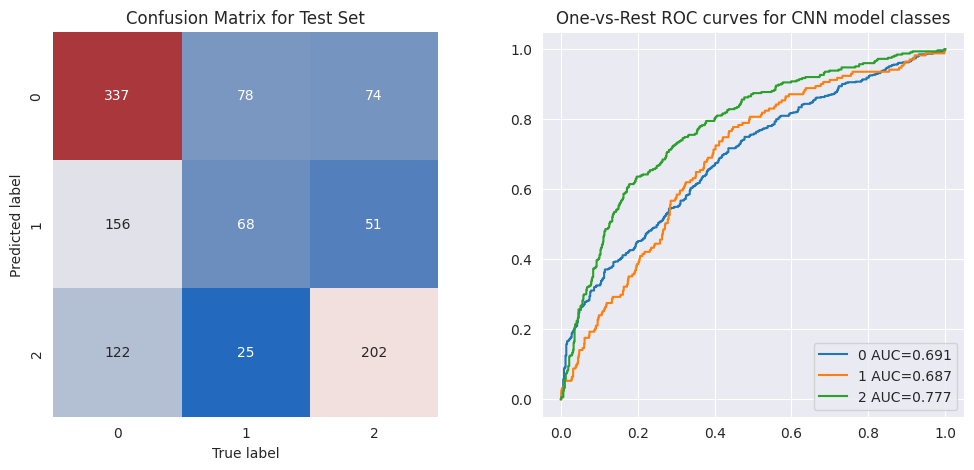

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassROC

# Confusion matrix of CNN after 5 epochs
outputs, labels, _ = generate_outputs(net_final, 'mspec', test)
predictions = calculate_predictions(outputs)

confmat1 = confusion_matrix(labels, predictions)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confmat1.T,
            square=True,
            annot=True,
            fmt='d',
            cmap='vlag',
            cbar=False,
            ax=ax1)

# ROC Curve
metric = MulticlassROC(num_classes=3)
metric.update(outputs, labels)
_fix, _ax = metric.plot(score=True, ax=ax2)

ax2.set_title("One-vs-Rest ROC curves for CNN model classes")
ax2.legend(fontsize="10", loc ="lower right")

ax1.set(title='Confusion Matrix for Test Set', xlabel='True label', ylabel='Predicted label');
#fig.savefig("cnn_metrics.png")

In [ ]:
# Train for a further 20 epochs just to see test accuracy.
net15 = train_model(net_final, 'mspec', epochs=20)

  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[1] test loss,  test accuracy: 33.450, 0.5336927223719676. train loss, train accuracy: 1622.818, 0.8455057754850286


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[2] test loss,  test accuracy: 34.638, 0.5265049415992812. train loss, train accuracy: 1386.438, 0.8689932152069082


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[3] test loss,  test accuracy: 36.204, 0.4995507637017071. train loss, train accuracy: 1214.739, 0.8871116967589997


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[4] test loss,  test accuracy: 37.349, 0.504941599281222. train loss, train accuracy: 1075.888, 0.900660255691376


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[5] test loss,  test accuracy: 41.427, 0.5076370170709793. train loss, train accuracy: 957.887, 0.9132625883144555


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[6] test loss,  test accuracy: 51.147, 0.49326145552560646. train loss, train accuracy: 864.707, 0.9223954244701132


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[7] test loss,  test accuracy: 54.837, 0.4968553459119497. train loss, train accuracy: 784.430, 0.9304418526410227


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[8] test loss,  test accuracy: 55.350, 0.4941599281221923. train loss, train accuracy: 713.329, 0.9369042278793316


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[9] test loss,  test accuracy: 53.347, 0.5220125786163522. train loss, train accuracy: 677.394, 0.9410115509700572


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[10] test loss,  test accuracy: 61.485, 0.5220125786163522. train loss, train accuracy: 606.889, 0.9473898172030952


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[11] test loss,  test accuracy: 56.372, 0.518418688230009. train loss, train accuracy: 586.252, 0.9494574969160031


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[12] test loss,  test accuracy: 64.951, 0.522911051212938. train loss, train accuracy: 534.714, 0.9541956375462599


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[13] test loss,  test accuracy: 65.150, 0.5265049415992812. train loss, train accuracy: 510.037, 0.956473589772345


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[14] test loss,  test accuracy: 65.743, 0.5372866127583109. train loss, train accuracy: 493.445, 0.959256196030055


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[15] test loss,  test accuracy: 73.944, 0.5372866127583109. train loss, train accuracy: 453.395, 0.9617163844342268


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[16] test loss,  test accuracy: 82.637, 0.48966756513926324. train loss, train accuracy: 431.260, 0.9641976000897162


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[17] test loss,  test accuracy: 82.678, 0.5067385444743935. train loss, train accuracy: 414.408, 0.9654031624985981


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[18] test loss,  test accuracy: 82.440, 0.522911051212938. train loss, train accuracy: 421.563, 0.9652419535718291


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[19] test loss,  test accuracy: 81.804, 0.5121293800539084. train loss, train accuracy: 374.629, 0.9689217225524279


  0%|          | 0/4459 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[20] test loss,  test accuracy: 94.135, 0.48427672955974843. train loss, train accuracy: 365.433, 0.9701132667937648
Finished Training


([1622.8176894336939,
  1386.4375148303807,
  1214.739313416183,
  1075.8878328558058,
  957.8873230712488,
  864.7071212986484,
  784.4303647847846,
  713.3289337255992,
  677.3942921482958,
  606.8892610550392,
  586.2518462750595,
  534.7140477433568,
  510.0368830433581,
  493.44545494706836,
  453.39538217463996,
  431.2604200502392,
  414.4081912614638,
  421.562933307403,
  374.62864198937314,
  365.43342406839656],
 [0.8455057754850286,
  0.8689932152069082,
  0.8871116967589997,
  0.900660255691376,
  0.9132625883144555,
  0.9223954244701132,
  0.9304418526410227,
  0.9369042278793316,
  0.9410115509700572,
  0.9473898172030952,
  0.9494574969160031,
  0.9541956375462599,
  0.956473589772345,
  0.959256196030055,
  0.9617163844342268,
  0.9641976000897162,
  0.9654031624985981,
  0.9652419535718291,
  0.9689217225524279,
  0.9701132667937648],
 [33.45046281814575,
  34.63766658306122,
  36.204177021980286,
  37.348814725875854,
  41.42718040943146,
  51.14672291278839,
  54.83

#### Visualisations

The code for training history visualisations used in the dissertation was performed in another file. The code for the confusion matrix and ROC curve for the `final_net` model after 5 epochs was completed in this file.

### Reference list

Librosa 0.10.1 documentation: https://librosa.org/doc/main/

Precision-Recall, Scikit-learn 1.3.0 documentation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#:~:text=Precision%2Drecall%20curves%20are%20typically,necessary%20to%20binarize%20the%20output.